## Setup

In [1]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-oa_y62v4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-oa_y62v4
  Resolved https://github.com/tensorflow/docs to commit a8576cef38b7182e6228d7aafca8ef51754ab9e8
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=a48f270a732fc17b8003b1028df5319b55ac17b72d442b686f0ab350e083400e
  Stored in directory: /tmp/pip-ephem-wheel-cache-dmxytm7x/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


In [33]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_datasets as tfds

In [37]:
train_size = 50000
test_size = 10000
batch_size = 32

## Load the CelebA dataset


In [38]:
# Load the full CelebA dataset
dataset = tfds.load("celeb_a", split="train", shuffle_files=True)

# Preprocessing function
def preprocess(example):
    image = tf.image.resize(example['image'], (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Apply preprocessing
dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Split into train and test datasets manually
train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.skip(train_size).take(test_size).shuffle(test_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [40]:
class CVAE(tf.keras.Model):
    """Convolutional Variational Autoencoder for 64x64x3 images."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(32, 4, strides=2, activation='relu'),  # -> 31x31x32
            tf.keras.layers.Conv2D(64, 4, strides=2, activation='relu'),  # -> 14x14x64
            tf.keras.layers.Conv2D(128, 4, strides=2, activation='relu'), # -> 6x6x128
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),  # for mean and logvar
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),  # 16x16
            tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),   # 32x32
            tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu'),   # 64x64
            tf.keras.layers.Conv2DTranspose(3, 3, strides=1, padding='same'),  # Output logits
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits


In [41]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [42]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [43]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].numpy())  # No need to index channel
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [44]:
num_examples_to_generate = 16  # or any number ≤ batch_size
assert batch_size >= num_examples_to_generate

# Take one batch from the test dataset
for test_batch in test_dataset.take(1):
    test_sample = test_batch[:num_examples_to_generate]  # shape: (16, 64, 64, 3)


Epoch: 10, Test set ELBO: -7205.3516, Time elapsed: 35.16s


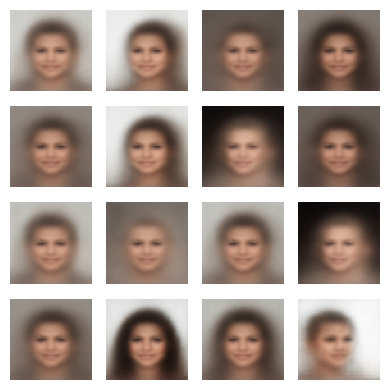

In [45]:
# Generate initial images from untrained model
generate_and_save_images(model, 0, test_sample)

# Training loop
for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training phase
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    end_time = time.time()

    # Evaluation phase (ELBO on test set)
    test_loss_metric = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        test_loss_metric(compute_loss(model, test_x))
    elbo = -test_loss_metric.result()

    # Display progress and generate sample images
    display.clear_output(wait=True)
    print(f'Epoch: {epoch}, Test set ELBO: {elbo:.4f}, Time elapsed: {end_time - start_time:.2f}s')
    generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [46]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

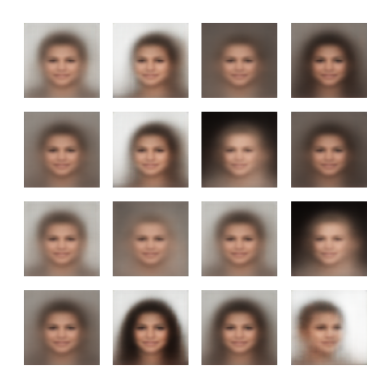

In [47]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [48]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-48-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-48-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



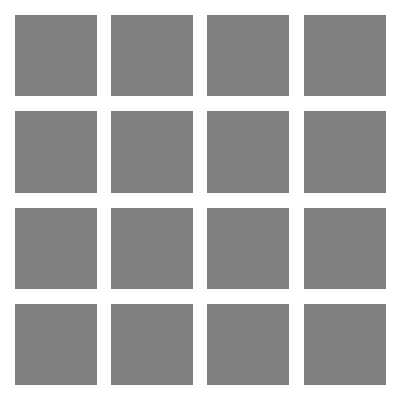

In [50]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [55]:
def plot_latent_images(model, n, digit_size=64):  # Changed digit_size to 64
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width, 3))  # Added 3rd dimension for RGB

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 3))  # Reshape to 64x64x3
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size, :] = digit.numpy()  # Added slicing for 3rd dimension

    plt.figure(figsize=(10, 10))
    plt.imshow(image)  # Removed cmap since it's RGB
    plt.axis('Off')
    plt.show()

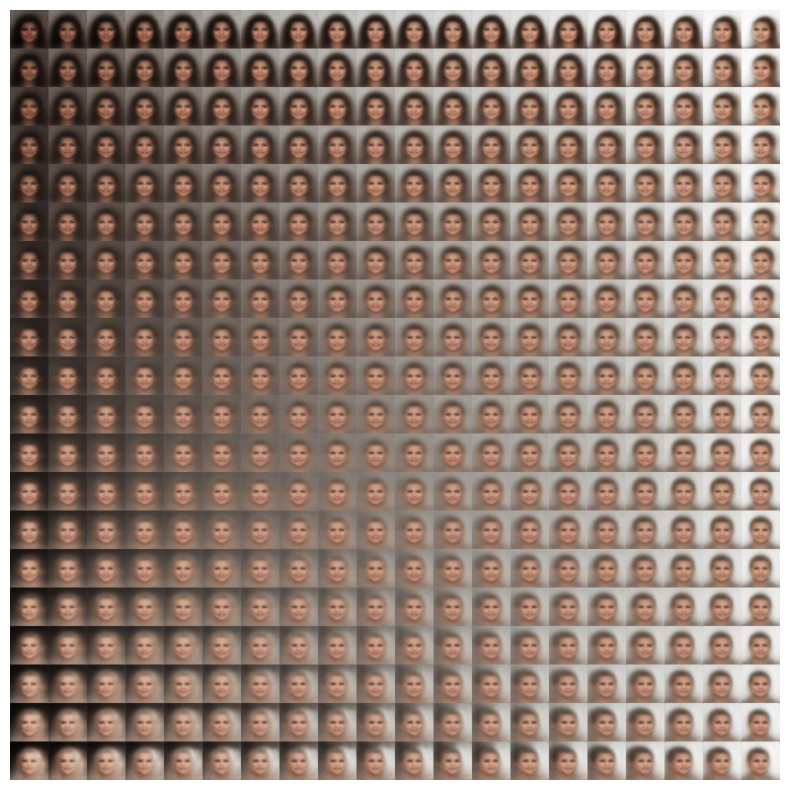

In [56]:
plot_latent_images(model, 20)

## Next steps

This tutorial has demonstrated how to implement a convolutional variational autoencoder using TensorFlow.

As a next step, you could try to improve the model output by increasing the network size.
For instance, you could try setting the `filter` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512.
Note that in order to generate the final 2D latent image plot, you would need to keep `latent_dim` to 2. Also, the training time would increase as the network size increases.

You could also try implementing a VAE using a different dataset, such as CIFAR-10.

VAEs can be implemented in several different styles and of varying complexity. You can find additional implementations in the following sources:
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

If you'd like to learn more about the details of VAEs, please refer to [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).